In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import comb, exp, factorial, log

## Section 6.1: Probability {-}

### Section 6.1.1: Frequentist versus Bayesian {-}

### Section 6.1.2: Definition and Axioms {-}

### Section 6.1.3: Permutations {-}

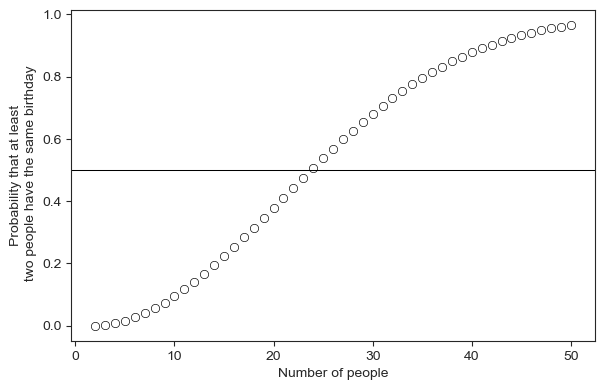

In [2]:
def birthday(k):
    logdenom = k * log(365) + log(factorial(365 - k)) # log denominator
    lognumer = log(factorial(365)) # log numerator
    # P(at least two have the same bday) = 1 - P(nobody has the same bday)
    pr = 1 - exp(lognumer - logdenom) # transform back
    return pr

k = pd.Series(np.arange(1, 51))

bday = k.apply(birthday) # apply the function to each element of k

bday.index = k # add labels 

sns.set_style('ticks')

sns.relplot(
    x=k, y=bday, color='white', edgecolor='black', height=4, aspect=1.5
).set(ylabel='Probability that at least\n two people have the same birthday',
      xlabel='Number of people').despine(right=False, top=False)

# horizontal line at 0.5
plt.axhline(0.5, color='black', linewidth=0.75)

In [3]:
bday.loc[20:25]

20    0.411438
21    0.443688
22    0.475695
23    0.507297
24    0.538344
25    0.568700
dtype: float64

### Section 6.1.4: Sampling With and Without Replacement {-}

In [4]:
k = 23 # number of people
sims = 10000 # number of simulations
event = 0 # initialize counter

for i in range(sims):
    days = np.random.choice(np.arange(1,366), size=k, replace=True)
    days_unique = np.unique(days) # number of unique days
    '''
    if there are duplicates, the number of unique birthdays will be less than
    the number of birthdays, which is 'k'
    '''
    if len(days_unique) < len(days):
        event += 1

answer = event / sims
answer

0.5079

### Section 6.1.5: Combinations {-}

In [5]:
comb(84, 6)

406481544

## Section 6.2: Conditional Probability {-}

### Section 6.2.1: Conditional, Marginal, and Joint Probabilities {-}

In [6]:
FLVoters = pd.read_csv('FLVoters.csv')

FLVoters.shape # before removal of missing data

(10000, 6)

In [7]:
FLVoters.info() # there is one missing surname

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   surname  9999 non-null   object 
 1   county   10000 non-null  int64  
 2   VTD      10000 non-null  int64  
 3   age      9992 non-null   float64
 4   gender   9992 non-null   object 
 5   race     9126 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 468.9+ KB


In [8]:
# print the record with the missing surname
FLVoters[FLVoters['surname'].isnull()]

,surname,county,VTD,age,gender,race
349,NaN,5,14,70.0,f,white


Looking at the raw data, it turns out that one voter's surname is Null. Pandas treated the name as missing. We need to override this behavior and treat Ms. Null's name as a string.

In [9]:
FLVoters.head() # the surnames are in all caps

,surname,county,VTD,age,gender,race
0,PIEDRA,115,66,58.0,f,white
1,LYNCH,115,13,51.0,m,white
2,CHESTER,115,103,63.0,m,NaN
3,LATHROP,115,80,54.0,m,white
4,HUMMEL,115,8,77.0,f,white


In [10]:
FLVoters['surname'] = np.where(
    FLVoters['surname'].isnull(), 'NULL', FLVoters['surname'])

FLVoters = FLVoters.dropna()

FLVoters.shape # after removal of missing data

(9113, 6)

In [11]:
margin_race = FLVoters['race'].value_counts(normalize=True).sort_index()

margin_race

race
asian       0.019203
black       0.131022
hispanic    0.130802
native      0.003182
other       0.034017
white       0.681773
Name: proportion, dtype: float64

In [12]:
margin_gender = FLVoters['gender'].value_counts(normalize=True)

margin_gender

gender
f    0.535828
m    0.464172
Name: proportion, dtype: float64

In [13]:
FLVoters['race'][FLVoters.gender == 'f'].value_counts(
    normalize=True).sort_index()

race
asian       0.016998
black       0.138849
hispanic    0.136392
native      0.003481
other       0.032357
white       0.671923
Name: proportion, dtype: float64

In [14]:
joint_p = pd.crosstab(FLVoters.race, FLVoters.gender, normalize=True)

joint_p

gender,f,m
race,,
asian,0.009108,0.010095
black,0.074399,0.056622
hispanic,0.073082,0.057720
native,0.001865,0.001317
other,0.017338,0.016679
white,0.360035,0.321738


To obtain the row sums in pandas, we specify `axis='columns'` in the `.sum()` method. This may seem counterintuitive, but the logic is that we need to collapse the columns to calculate the sum of each row.

In [15]:
# row sums
joint_p.sum(axis='columns')

race
asian       0.019203
black       0.131022
hispanic    0.130802
native      0.003182
other       0.034017
white       0.681773
dtype: float64

In [16]:
# column sums
joint_p.sum(axis='rows')

gender
f    0.535828
m    0.464172
dtype: float64

In [17]:
# Develop age group categories; start with a list of n-1 conditions
conditions = [
      (FLVoters.age <= 20)
    , (FLVoters.age > 20) & (FLVoters.age <= 40)
    , (FLVoters.age > 40) & (FLVoters.age <= 60)
]

choices  = [1, 2, 3]

# Assign 4 to voters older than 60
FLVoters["age_group"] = np.select(conditions, choices, 4)

joint3 = pd.crosstab([FLVoters.race, FLVoters.age_group], FLVoters.gender,
                     normalize=True)

# print the first 8 rows
joint3.head(8)

gender                  f         m
race  age_group                    
asian 1          0.000110  0.000219
      2          0.002634  0.002853
      3          0.004170  0.005157
      4          0.002195  0.001865
black 1          0.001646  0.001646
      2          0.028092  0.022825
      3          0.025787  0.018984
      4          0.018874  0.013168

In [18]:
# marginal probabilities for age groups
margin_age = FLVoters['age_group'].value_counts(normalize=True).sort_index()

margin_age

age_group
1    0.017667
2    0.270932
3    0.360474
4    0.350927
Name: proportion, dtype: float64

In [19]:
# take a look at the joint3 index for a few observations
joint3.index[:3]

MultiIndex([('asian', 1),
            ('asian', 2),
            ('asian', 3)],
           names=['race', 'age_group'])

In [20]:
# select elements from a multi-index using .loc and tuples
joint3.loc[('asian', 3), 'f']

0.004169867222648963

In [21]:
# P(black and female | above 60)
joint3.loc[('black', 4), 'f'] / margin_age[4]

0.05378361475922452

In [22]:
# two-way joint probability table for age group and gender
joint2 = pd.crosstab(FLVoters['age_group'], FLVoters['gender'], 
                     normalize=True)

joint2

gender,f,m
age_group,,
1,0.009657,0.008011
2,0.143092,0.127839
3,0.189839,0.170635
4,0.193240,0.157687


In [23]:
# P(above 60 and female)
joint2.loc[4, 'f']

0.1932404257653901

In [24]:
# P(black | female and above 60)
joint3.loc[('black', 4), 'f'] / joint2.loc[4, 'f']

0.097671777399205

### Section 6.2.2: Independence {-}

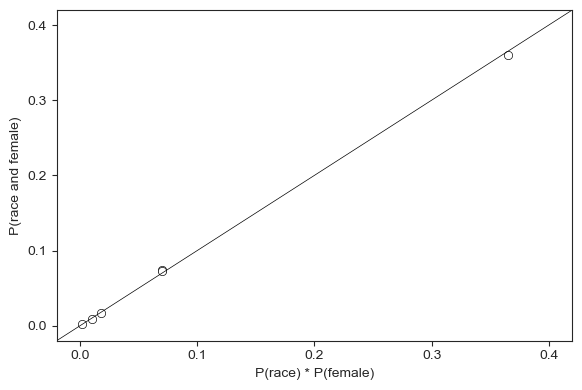

In [25]:
# store plotting parameters
lims = (-0.02, 0.42)
ticks = [0, .1, .2, .3, .4]

sns.relplot(
    x=margin_race * margin_gender['f'], y=joint_p['f'],
    color='white', edgecolor='black', height=4, aspect=1.5
).set(xlabel='P(race) * P(female)', ylabel='P(race and female)',
      xlim=lims, ylim=lims, xticks=ticks, yticks=ticks).despine(
          right=False, top=False)

plt.gca().axline((0, 0), slope=1, color='black', linewidth=0.5)

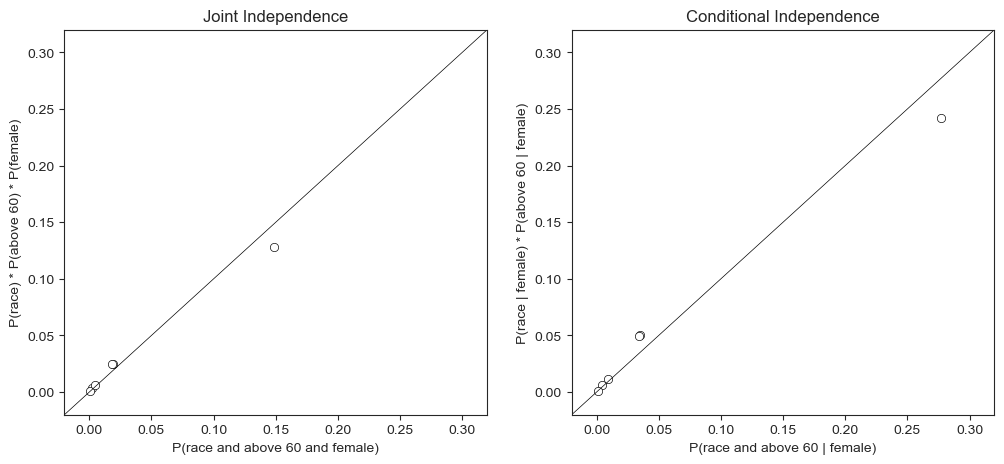

In [26]:
# subplots for joint and conditional independence
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

lims = (-0.02, 0.32)

# joint independence
sns.scatterplot(
    x=joint3.loc[(slice(None), 4), 'f'].droplevel('age_group'), 
    y=margin_race * margin_age[4] * margin_gender['f'],
    color='white', edgecolor='black', ax=axs[0]
).set(xlabel='P(race and above 60 and female)', 
      ylabel='P(race) * P(above 60) * P(female)',
      title='Joint Independence', xlim=lims, ylim=lims)

axs[0].axline((0, 0), slope=1, color='black', linewidth=0.5)

# conditional independence given female
sns.scatterplot(
    x=(joint3.loc[(slice(None), 4), 'f'] / 
       margin_gender['f']).droplevel('age_group'), 
    y=((joint_p['f'] / margin_gender['f']) * 
       (joint2.loc[4, 'f'] / margin_gender['f'])),
    color='white', edgecolor='black', ax=axs[1]
).set(xlabel='P(race and above 60 | female)', 
      ylabel='P(race | female) * P(above 60 | female)',
      title='Conditional Independence', xlim=lims, ylim=lims)

axs[1].axline((0, 0), slope=1, color='black', linewidth=0.5)

In [27]:
# Monty Hall problem
sims = 1000
doors = np.array(['goat', 'goat', 'car'])
# Store empty vector of strings with same dtype as doors
result_switch = np.empty(sims, dtype=doors.dtype)
result_noswitch = np.empty(sims, dtype=doors.dtype)

for i in range(sims):
    # randomly choose the initial door
    first = np.random.choice(np.arange(0,3))
    result_noswitch[i] = doors[first]
    remain = np.delete(doors, first) # remaining two doors
    if doors[first] == 'car': # two goats left
        monty = np.random.choice(np.arange(0,2))
    else: # one goat and one car left
        monty = np.arange(0,2)[remain=='goat']
    result_switch[i] = np.delete(remain, monty)[0]

(result_noswitch == 'car').mean()

0.311

In [28]:
(result_switch == 'car').mean()

0.689

### Section 6.2.3: Bayes' Rule {-}

### Section 6.2.4: Predicting Race Using Surname and Residence Location {-}

In [29]:
cnames = pd.read_csv('names.csv')

cnames.info() # one surname is missing

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151671 entries, 0 to 151670
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   surname      151670 non-null  object 
 1   count        151671 non-null  int64  
 2   pctwhite     151671 non-null  float64
 3   pctblack     151671 non-null  float64
 4   pctapi       151671 non-null  float64
 5   pcthispanic  151671 non-null  float64
 6   pctothers    151671 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 8.1+ MB


In [30]:
# As with FLVoters, ensure the surname "NULL" is treated as a string
cnames['surname'] = np.where(
    cnames['surname'].isnull(), 'NULL', cnames['surname'])

cnames.shape

(151671, 7)

In [31]:
# merge the two data frames (inner join)
FLVoters = pd.merge(FLVoters, cnames, on='surname')

FLVoters.shape

(8022, 13)

In [32]:
# store relevant variables
vars = ["pctwhite", "pctblack", "pctapi", "pcthispanic", "pctothers"]

# Whites 
whites = FLVoters.loc[FLVoters.race == 'white'].copy()
(whites[vars].max(axis='columns') == whites['pctwhite']).mean()

0.950218023255814

In [33]:
# Blacks
blacks = FLVoters.loc[FLVoters.race == 'black'].copy()
(blacks[vars].max(axis='columns') == blacks['pctblack']).mean()

0.16048237476808905

In [34]:
# Hispanics
hispanics = FLVoters.loc[FLVoters.race == 'hispanic'].copy()
(hispanics[vars].max(axis='columns') == hispanics['pcthispanic']).mean()

0.8465298142717498

In [35]:
# Asian
asians = FLVoters.loc[FLVoters.race == 'asian'].copy()
(asians[vars].max(axis='columns') == asians['pctapi']).mean()

0.5642857142857143

In [36]:
# White false discovery rate 
1 - (FLVoters['race'][FLVoters[vars].max(axis='columns') == 
                      FLVoters['pctwhite']] == "white").mean()

0.19736034376918354

In [37]:
# Black false discovery rate
1 - (FLVoters['race'][FLVoters[vars].max(axis='columns') == 
                      FLVoters['pctblack']] == "black").mean()

0.3294573643410853

In [38]:
# Hispanic false discovery rate
1 - (FLVoters['race'][FLVoters[vars].max(axis='columns') == 
                      FLVoters['pcthispanic']] == "hispanic").mean()

0.22747546833184662

In [39]:
# Asian false discovery rate
1 - (FLVoters['race'][FLVoters[vars].max(axis='columns') == 
                      FLVoters['pctapi']] == "asian").mean()

0.3416666666666667

In [40]:
FLCensus = pd.read_csv('FLCensusVTD.csv')

# compute proportions by applying np.average to each column with pop weight
census_race = ['white', 'black', 'api', 'hispanic', 'others']

race_prop = FLCensus[census_race].apply(
    lambda x: np.average(x, weights=FLCensus['total.pop']))

race_prop # race proportions in Florida

white       0.578934
black       0.151644
api         0.024197
hispanic    0.224655
others      0.020570
dtype: float64

In [41]:
# store total count from original cnames data
total_count = cnames['count'].sum()

# P(surname | race) = P(race | surname) * P(surname) / P(race) in Florida
FLVoters['name_white'] = (
       (FLVoters['pctwhite'] / 100) * (FLVoters['count'] / total_count) /
       race_prop['white'])

FLVoters['name_black'] = (
       (FLVoters['pctblack'] / 100) * (FLVoters['count'] / total_count) /
       race_prop['black'])

FLVoters['name_hispanic'] = (
       (FLVoters['pcthispanic'] / 100) * (FLVoters['count'] / total_count) /
       race_prop['hispanic'])

FLVoters['name_asian'] = (
       (FLVoters['pctapi'] / 100) * (FLVoters['count'] / total_count) /
       race_prop['api'])

FLVoters['name_others'] = (
       (FLVoters['pctothers'] / 100) * (FLVoters['count'] / total_count) /
       race_prop['others'])

In [42]:
# merge FLVoters with FLCensus by county and VTD using left join
FLVoters = pd.merge(FLVoters, FLCensus, on=['county', 'VTD'], how='left')

# P(surname | residence) = sum_race P(surname | race) P(race | residence)
FLVoters['name_residence'] = (
    FLVoters['name_white'] * FLVoters['white'] + 
    FLVoters['name_black'] * FLVoters['black'] + 
    FLVoters['name_hispanic'] * FLVoters['hispanic'] + 
    FLVoters['name_asian'] * FLVoters['api'] + 
    FLVoters['name_others'] * FLVoters['others'])

In [43]:
'''
P(race | surname, residence) = P(surname | race) * P(race | residence) /
P(surname | residence)
'''

FLVoters['pre_white'] = (FLVoters.name_white * FLVoters.white / 
                         FLVoters.name_residence)

FLVoters['pre_black'] = (FLVoters.name_black * FLVoters.black /
                         FLVoters.name_residence)

FLVoters['pre_hispanic'] = (FLVoters.name_hispanic * FLVoters.hispanic /
                            FLVoters.name_residence)

FLVoters['pre_asian'] = (FLVoters.name_asian * FLVoters.api /
                         FLVoters.name_residence)

FLVoters['pre_others'] = (1 - FLVoters.pre_white - FLVoters.pre_black -
                          FLVoters.pre_hispanic - FLVoters.pre_asian)

In [44]:
# relevant variables
vars1 = ['pre_white', 'pre_black', 'pre_hispanic', 'pre_asian', 'pre_others']

# Whites 
whites = FLVoters.loc[FLVoters.race == 'white'].copy()
(whites[vars1].max(axis='columns') == whites['pre_white']).mean()

0.9418604651162791

In [45]:
# Blacks
blacks = FLVoters.loc[FLVoters.race == 'black'].copy()
(blacks[vars1].max(axis='columns') == blacks['pre_black']).mean()

0.62708719851577

In [46]:
# Hispanics
hispanics = FLVoters.loc[FLVoters.race == 'hispanic'].copy()
(hispanics[vars1].max(axis='columns') == hispanics['pre_hispanic']).mean()

0.8572825024437928

In [47]:
# Asians
asians = FLVoters.loc[FLVoters.race == 'asian'].copy()
(asians[vars1].max(axis='columns') == asians['pre_asian']).mean()

0.6071428571428571

In [48]:
# proportion of blacks among those with surname "White"
cnames['pctblack'][cnames.surname == "WHITE"]

19    27.38
Name: pctblack, dtype: float64

In [49]:
# predicted probability of being black given residence location 
FLVoters['pre_black'][FLVoters.surname == "WHITE"].describe()

count    24.000000
mean      0.250711
std       0.293894
min       0.004588
25%       0.072232
50%       0.159496
75%       0.293640
max       0.981864
Name: pre_black, dtype: float64

In [50]:
# Whites
1 - (FLVoters['race'][FLVoters[vars1].max(axis='columns') == 
                      FLVoters['pre_white']] == "white").mean()


0.12239715591670897

In [51]:
# Blacks
1 - (FLVoters['race'][FLVoters[vars1].max(axis='columns') == 
                      FLVoters['pre_black']] == "black").mean()

0.22029988465974626

In [52]:
# Hispanics
1 - (FLVoters['race'][FLVoters[vars1].max(axis='columns') == 
                      FLVoters['pre_hispanic']] == "hispanic").mean()

0.21133093525179858

In [53]:
# Asians
1 - (FLVoters['race'][FLVoters[vars1].max(axis='columns') == 
                      FLVoters['pre_asian']] == "asian").mean()

0.3307086614173228

## Section 6.3: Random Variables and Probability Distributions {-}

### Section 6.3.1: Random Variables {-}

### Section 6.3.2: Bernoulli and Uniform Distributions {-}

In [54]:
from scipy import stats

# uniform PDF: x = 0.5, interval = [0,1]
stats.uniform.pdf(x=0.5, loc=0, scale=1) # loc = a, scale = b-a

1.0

In [55]:
# uniform CDF: x = 1, interval = [-2, 2]
a = -2
b = 2
stats.uniform.cdf(x=1, loc=a, scale=b-a)

0.75

In [56]:
sims = 1000
p = 0.5 # success probabilities
x = stats.uniform.rvs(size=sims, loc=0, scale=1)

type(x) # a numpy array

numpy.ndarray

In [57]:
x[:6]

array([0.14432593, 0.24617993, 0.33183618, 0.38388235, 0.26991479,
       0.93488133])

In [58]:
y = (x <= p).astype(int)
y[:6]

array([1, 1, 1, 1, 1, 0])

In [59]:
y.mean() # close to success probability p, proportion of 1's vs. 0's

0.506

### Section 6.3.3: Binomial Distribution {-}

In [60]:
# PMF: k = 2, n = 3, p = 0.5
stats.binom.pmf(k=2, n=3, p=0.5)

0.3750000000000001

In [61]:
# CDF: k = 1, n = 3, p = 0.5
stats.binom.cdf(k=1, n=3, p=0.5)

0.5

In [62]:
# number of voters who turn out 
voters = np.array([1000, 10000, 100000])

stats.binom.pmf(voters/2, n=voters, p=0.5)

array([0.02522502, 0.00797865, 0.00252313])

### Section 6.3.4: Normal Distribution {-}

In [63]:
# plus minus 1 standard deviation from the mean
stats.norm.cdf(1) - stats.norm.cdf(-1)

0.6826894921370859

In [64]:
# plus minus 2 standard deviations from the mean
stats.norm.cdf(2) - stats.norm.cdf(-2)

0.9544997361036416

In [65]:
mu = 5
sigma = 2

# plus minus 1 standard deviation from the mean
(stats.norm.cdf(mu + sigma, loc=mu, scale=sigma) - 
 stats.norm.cdf(mu - sigma, loc=mu, scale=sigma))

0.6826894921370859

In [66]:
# plus minus 2 standard deviations from the mean
(stats.norm.cdf(mu + 2*sigma, loc=mu, scale=sigma) - 
 stats.norm.cdf(mu - 2*sigma, loc=mu, scale=sigma))

0.9544997361036416

In [67]:
# Replicate model from 4.2.5
pres08 = pd.read_csv('pres08.csv')

# import pres12 from the PREDICTION folder
pres12 = pd.read_csv('../PREDICTION/pres12.csv')

# merge the two elections by state
pres = pd.merge(pres08, pres12, on='state')

# Use the scipy zscore function to standardize Obama's vote share
# Set ddof=1 to ensure the standard deviation denominator is n-1
pres['Obama2008_z'] = stats.zscore(pres['Obama_x'], ddof=1)
pres['Obama2012_z'] = stats.zscore(pres['Obama_y'], ddof=1)

*Note that in chapter 4, we built a function to calculate the z-score using the pandas `.std()` method. The default ddof=1 for the pandas method. By contrast, the default ddof=0 for the numpy `std` function and the scipy `zscore` function.*

In [68]:
import statsmodels.formula.api as smf

fit1 = smf.ols('Obama2012_z ~ -1 + Obama2008_z', data=pres).fit()

e = fit1.resid

# z-score of residuals
e_zscore = stats.zscore(e, ddof=1) 

# alternatively, we can divide the residuals by the standard deviation
e_zscore = e / np.std(e, ddof=1)

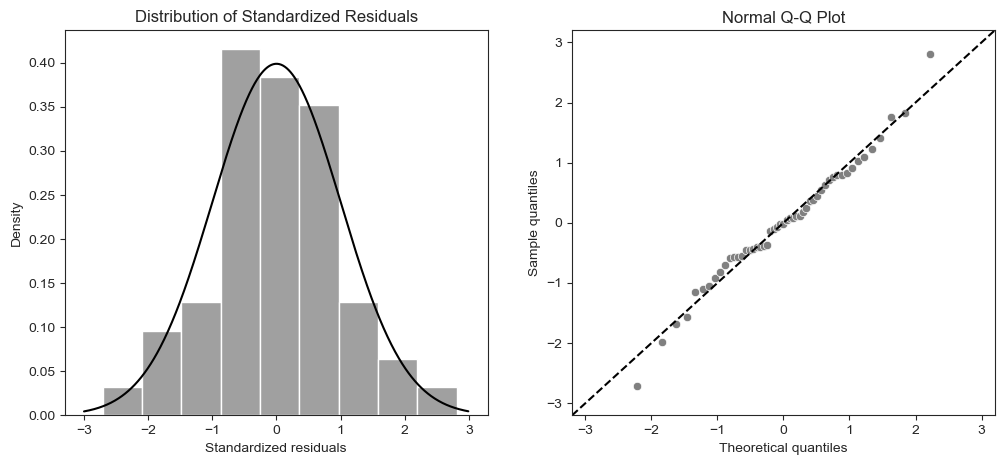

In [69]:
# Plot a histogram and Q-Q plot of the standardized residuals

## First, calculate some inputs for the plots
x = np.arange(-3, 3, 0.01)
y = stats.norm.pdf(x) # PDF of x

## Find quantiles for Q-Q plot using scipy.stats.probplot
quantiles = stats.probplot(e_zscore)
osm = quantiles[0][0] # ordered statistic medians (theoretical quantiles)
osr = quantiles[0][1] # ordered statistic ranks (sample quantiles)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Histogram of residuals
sns.histplot(e_zscore, stat='density', color='gray', ax=axs[0]).set(
    xlabel='Standardized residuals',
    title='Distribution of Standardized Residuals')

# Overlay the normal density 
sns.lineplot(x=x, y=y, color='black', ax=axs[0])

# Q-Q plot
sns.scatterplot(x=osm, y=osr, color='gray', ax=axs[1]).set(
    xlabel='Theoretical quantiles', ylabel='Sample quantiles',
    title='Normal Q-Q Plot', xlim=(-3.2, 3.2), ylim=(-3.2, 3.2))

# 45-degree line
axs[1].axline((0, 0), slope=1, color='black', linestyle='--')

*Note that we could have used `probplot` to create a Q-Q plot directly by 
passing a plot or an axis to the `plot` argument. However, obtaining the 
quantiles enables us to customize the plot a bit more.*

In [70]:
# e is a pandas series; we can use the pandas .std() method
e_sd = e.std()
e_sd

0.1812238619213575

In [71]:
CA_2008 = pres['Obama2008_z'][pres['state'] == 'CA']
CA_2008

4    0.872063
Name: Obama2008_z, dtype: float64

In [72]:
# CA_2008 is a series with index 4; extract the value using .iloc
CA_mean2012 = fit1.params * CA_2008.iloc[0]
CA_mean2012

Obama2008_z    0.857623
dtype: float64

In [73]:
# area to the right; greater than CA_2008
1 - stats.norm.cdf(CA_2008, loc=CA_mean2012, scale=e_sd)

array([0.46824629])

In [74]:
TX_2008 = pres['Obama2008_z'][pres['state'] == 'TX']
TX_mean2012 = fit1.params * TX_2008.iloc[0]
TX_mean2012

Obama2008_z   -0.656754
dtype: float64

In [75]:
1 - stats.norm.cdf(TX_2008, loc=TX_mean2012, scale=e_sd)

array([0.52432713])

### Section 6.3.5: Expectation and Variance {-}

**In Progress**